In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#root_dir = '/content/gdrive/MyDrive/Data'

root_dir = '../../../Data'

Mounted at /content/gdrive


In [2]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep

In [4]:
experience = 1

number_columns = 5
#number_columns = 3
#number_columns = 2

def construct_training_labels(number_columns, labels):
  n = labels.shape[0]
  training_labels = np.zeros((n,number_columns))
  for i in range(n):
    training_labels[i][labels[i]] = 1
  return training_labels

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_wake(val):
  arr = {'N1':0, 'N2':0, 'N3':0, 'REM':0, 'Wake':1, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_pos(val):
  arr = {'Supine;':0, 'Upright;':1, 'Right;':2, 'Prone;':3, 'Left;':4, 'Artefact;':np.NaN, 'A;':np.NaN}
  return arr[val]

def encode_sleep_hr(val):
  if val == 'A;':
    return np.NaN
  n = len(val)
  val = int(val[:n-1])
  if (val < 60):
    return 0
  if (val < 100 and val >= 60):
    return 1
  return 2

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

file_name = os.path.join(features_dir, "Unlabelled")
#file_name = os.path.join(features_dir, "UnlabelledHR")
#file_name = os.path.join(features_dir, "UnlabelledPOS")

unlabelled_dataset = pd.read_pickle(file_name)

file_name_stage = os.path.join(features_dir, "Labelled")
file_name_hr = os.path.join(features_dir, "LabelledHR")
file_name_pos = os.path.join(features_dir, "LabelledPOS")

labelled_dataset_stage = pd.read_pickle(file_name_stage)
labelled_dataset_wake = pd.read_pickle(file_name_stage)
labelled_dataset_hr = pd.read_pickle(file_name_hr)
labelled_dataset_pos = pd.read_pickle(file_name_pos)

OnLabel = ["Label",'Sleep State']

for i in range(49):
  OnLabel.append(str(i))

new_labelled_dataset = pd.merge(labelled_dataset_stage, labelled_dataset_pos, on=OnLabel)
merged_test_dataset = pd.merge(new_labelled_dataset, labelled_dataset_hr, on=OnLabel)
merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep State']

#print(new_labelled_dataset)

labels_stage = merged_test_dataset['Sleep State']
labels_wake = merged_test_dataset['Sleep Wake']
labels_pos = merged_test_dataset['Value_x']
labels_hr = merged_test_dataset['Value_y']

#print(labels_stage.unique())
#print(labels_wake.unique())
#print(labels_pos.unique())
#print(labels_hr.unique())
#print(unlabelled_dataset.shape)

save_sleep_labels_sleep_stage = os.path.join(features_dir, "SleepStageLabels.npy")
save_sleep_labels_sleep_wake = os.path.join(features_dir, "SleepWakeLabels.npy")
save_sleep_labels_sleep_pos = os.path.join(features_dir, "SleepPosLabels.npy")
save_sleep_labels_sleep_hr = os.path.join(features_dir, "SleepHRLabels.npy")

y_labels_stage = np.load(save_sleep_labels_sleep_stage)
y_labels_wake = np.load(save_sleep_labels_sleep_wake)
y_labels_pos = np.load(save_sleep_labels_sleep_pos)
y_labels_hr = np.load(save_sleep_labels_sleep_hr)

merged_test_dataset['Sleep State'] = merged_test_dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
merged_test_dataset['Sleep State'] = pd.Series(np.array(merged_test_dataset['Sleep State'])).interpolate()
merged_test_dataset['Sleep State'] = np.array(merged_test_dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep Wake'].apply(lambda x: encode_sleep_wake(x))
merged_test_dataset['Sleep Wake'] = pd.Series(np.array(merged_test_dataset['Sleep Wake'])).interpolate()
merged_test_dataset['Sleep Wake'] = np.array(merged_test_dataset['Sleep Wake'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: encode_sleep_pos(x))
#print(dataset['Value'].unique())
merged_test_dataset['Value_x'] = pd.Series(np.array(merged_test_dataset['Value_x'])).interpolate()
merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: int(x))

merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: encode_sleep_hr(x))
merged_test_dataset['Value_y'] = pd.Series(np.array(merged_test_dataset['Value_y'])).interpolate()
merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: int(x))

merged_test_dataset = merged_test_dataset.sample(frac=1).reset_index(drop=True)


y_labels_stage_values = np.array(merged_test_dataset['Sleep State'])
y_labels_wake_values = np.array(merged_test_dataset['Sleep Wake'])
y_labels_pos_values = np.array(merged_test_dataset['Value_x'])
y_labels_hr_values = np.array(merged_test_dataset['Value_y'])

y_test_stage = construct_training_labels(5, y_labels_stage_values)
y_test_wake = construct_training_labels(2, y_labels_wake_values)
y_test_pos = construct_training_labels(5, y_labels_pos_values)
y_test_hr = construct_training_labels(3, y_labels_hr_values)

y_train_stage = construct_training_labels(5, y_labels_stage)
y_train_wake = construct_training_labels(2, y_labels_wake)
y_train_pos = construct_training_labels(5, y_labels_pos)
y_train_hr = construct_training_labels(3, y_labels_hr)

x_test = np.array(merged_test_dataset.drop(['Label','Sleep State', 'Sleep Wake', 'Value_x', 'Value_y'], axis=1))
x_train = np.array(unlabelled_dataset.drop(['Label','Sleep State'], axis=1))

def split_trains_sets(train_set, split_ratio):
  n = train_set.shape[0]
  split_point = int(split_ratio * n)
  split_train_1 = train_set[:split_point]
  split_train_2 = train_set[split_point:]
  return split_train_1, split_train_2

train_split_ratio = 0.75

y_train_stage, additional_stage = split_trains_sets(y_train_stage, train_split_ratio)
y_train_wake, additional_wake = split_trains_sets(y_train_wake, train_split_ratio)
y_train_pos, additional_pos = split_trains_sets(y_train_pos, train_split_ratio)
y_train_hr, additional_hr = split_trains_sets(y_train_hr, train_split_ratio)

x_train, additional_train = split_trains_sets(x_train, train_split_ratio)

train_split_ratio = 0.9

y_test_stage, additional_test_stage = split_trains_sets(y_test_stage, train_split_ratio)
y_test_wake, additional_test_wake = split_trains_sets(y_test_wake, train_split_ratio)
y_test_pos, additional_test_pos = split_trains_sets(y_test_pos, train_split_ratio)
y_test_hr, additional_test_hr = split_trains_sets(y_test_hr, train_split_ratio)

x_test, additional_test = split_trains_sets(x_test, train_split_ratio)

y_test_stage = np.append(y_test_stage, additional_stage, axis=0)
y_test_wake = np.append(y_test_wake, additional_wake, axis=0)
y_test_pos = np.append(y_test_pos, additional_pos, axis=0)
y_test_hr = np.append(y_test_hr, additional_hr, axis=0)

x_test = np.append(x_test, additional_train, axis=0)

train_split_ratio = 0.9

y_train_stage, y_test_stage_f = split_trains_sets(y_train_stage, train_split_ratio)
y_train_wake, y_test_wake_f = split_trains_sets(y_train_wake, train_split_ratio)
y_train_pos, y_test_pos_f = split_trains_sets(y_train_pos, train_split_ratio)
y_train_hr, y_test_hr_f = split_trains_sets(y_train_hr, train_split_ratio)

x_train, x_test_f = split_trains_sets(x_train, train_split_ratio)

#Creating test sets
y_test_stage_f = np.append(y_test_stage_f, additional_test_stage, axis=0)
y_test_wake_f = np.append(y_test_wake_f, additional_test_wake, axis=0)
y_test_pos_f = np.append(y_test_pos_f, additional_test_pos, axis=0)
y_test_hr_f = np.append(y_test_hr_f, additional_test_hr, axis=0)

x_test_f = np.append(x_test_f, additional_test, axis=0)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1, 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1, 1))
x_test_f = x_test_f.reshape((x_test_f.shape[0], x_test_f.shape[1], 1, 1))

print(x_test.shape)
print(x_train.shape)
print(x_test_f.shape)


(139631, 49, 1, 1)
(334915, 49, 1, 1)
(38945, 49, 1, 1)


Multi-task

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 49, 1, 1)]   0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 49, 1, 100)   200         ['input[0][0]']                  
                                                                                                  
 act_1 (Activation)             (None, 49, 1, 100)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 49, 1, 20)    2020        ['act_1[0][0]']                  
                                                                                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


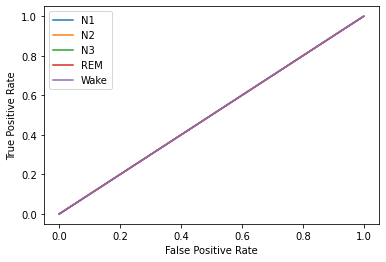

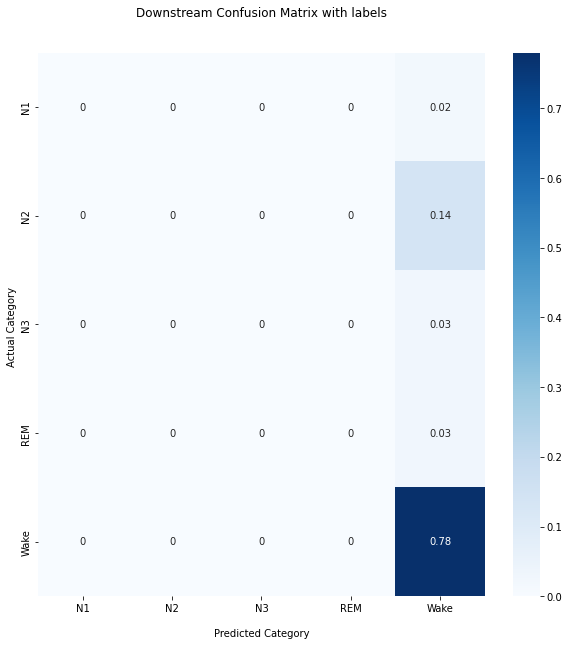

[[34966  9645]
 [10987 85765]]
Precision, Recall and F1 Score for Sleep are 0.76, 0.78, 0.77
Precision, Recall and F1 Score for Wake are 0.9, 0.89, 0.89
(2, 2)
Accuracy is 0.85
Performance is 0.83


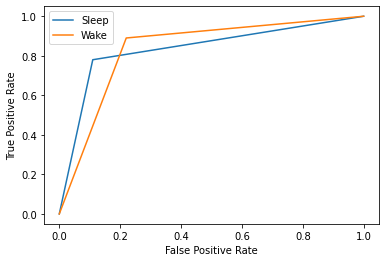

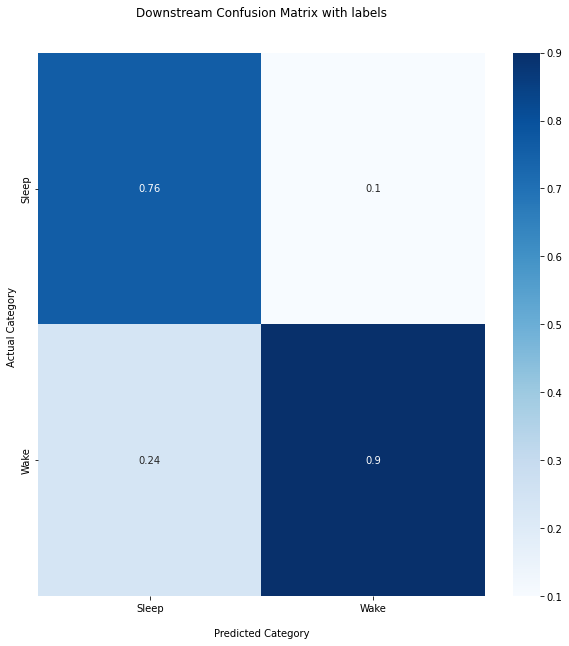

[[46444  1462  5444    31  2517]
 [ 5607 24058   103     2  2012]
 [ 8988    87 22856    26  1493]
 [  416    15   396     6   237]
 [ 8432  2296  1354     8  7073]]
Precision, Recall and F1 Score for Supine are 0.66, 0.83, 0.74
Precision, Recall and F1 Score for Upright are 0.86, 0.76, 0.81
Precision, Recall and F1 Score for Right are 0.76, 0.68, 0.72
Precision, Recall and F1 Score for Prone are 0.08, 0.01, 0.02
Precision, Recall and F1 Score for Left are 0.53, 0.37, 0.44
(5, 5)
Accuracy is 0.71
Performance is 0.55


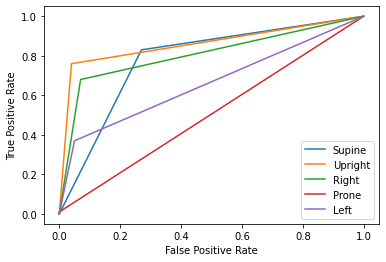

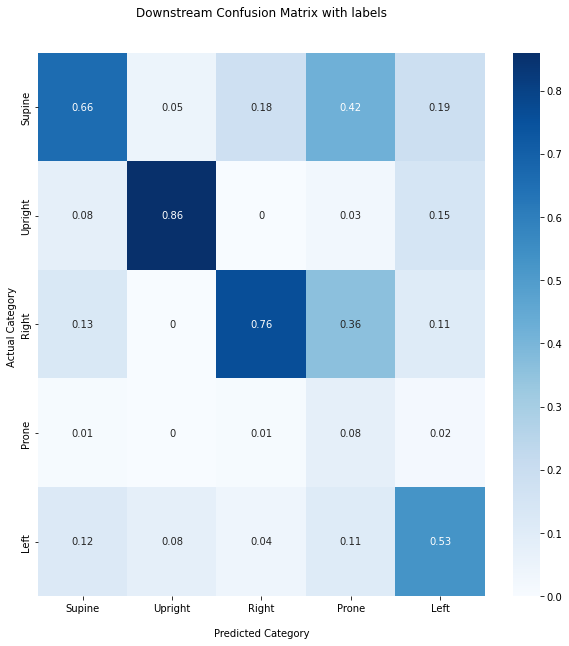

[[     0  24376      0]
 [     0 116749      0]
 [     0    238      0]]
Precision, Recall and F1 Score for Slow are nan, 0.0, nan
Precision, Recall and F1 Score for Normal are 0.83, 1.0, 0.91
Precision, Recall and F1 Score for Fast are nan, 0.0, nan
(3, 3)
Accuracy is 0.83
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


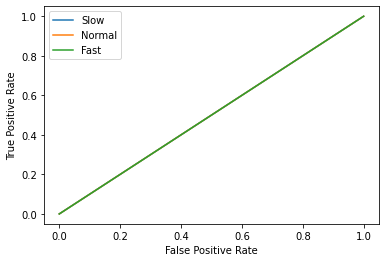

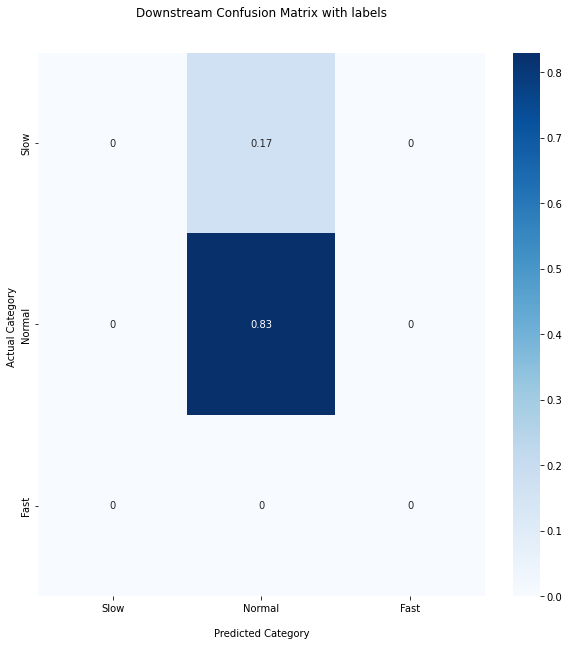

([nan, 0.83, nan], 0.83)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(x_train.shape[1],1,1), name='input')

conv_1 = Conv2D(100, kernel_size=(1,1), name='conv_1')(input_)
act_1 = Activation('relu', name='act_1')(conv_1)

conv_2 = Conv2D(20, kernel_size=(1,1), name='conv_2')(act_1)
act_2 = Activation('relu', name='act_2')(conv_2)

flat_1 = Flatten(name='flat_1')(act_2)

sleep_stage_dense_1 = Dense(10, activation='sigmoid', name='sleep_stage_dense_1')(flat_1)
sleep_stage_dense_2 = Dense(5, activation='softmax', name='sleep_stage_dense_2')(sleep_stage_dense_1)

sleep_wake_dense_1 = Dense(10, activation='sigmoid', name='sleep_wake_dense_1')(flat_1)
sleep_wake_dense_2 = Dense(2, activation='softmax', name='sleep_wake_dense_2')(sleep_wake_dense_1)

sleep_pos_dense_1 = Dense(10, activation='sigmoid', name='sleep_pos_dense_1')(flat_1)
sleep_pos_dense_2 = Dense(5, activation='softmax', name='sleep_pos_dense_2')(sleep_pos_dense_1)

sleep_hr_dense_1 = Dense(10, activation='sigmoid', name='sleep_hr_dense_1')(flat_1)
sleep_hr_dense_2 = Dense(3, activation='softmax', name='sleep_hr_dense_2')(sleep_hr_dense_1)

model = tf.keras.models.Model(input_, [sleep_stage_dense_2, sleep_wake_dense_2,sleep_pos_dense_2,sleep_hr_dense_2])
model.summary()

model.compile(
    loss={
        'sleep_stage_dense_2': 'categorical_crossentropy',
        'sleep_wake_dense_2': 'binary_crossentropy',
        'sleep_pos_dense_2': 'categorical_crossentropy',
        'sleep_hr_dense_2': 'categorical_crossentropy'
    },
    optimizer='RMSprop',
    metrics=['accuracy']
)

_ = model.fit(x_train, [y_train_stage, y_train_wake, y_train_pos, y_train_hr], validation_data=(x_test, [y_test_stage, y_test_wake, y_test_pos, y_test_hr]), 
              batch_size=16,epochs=50)

y_preds = model.predict(x_test_f)

test_labels = np.argmax(y_test_stage_f, axis=1)
y_pred = np.argmax(y_preds[:][0], axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_wake_f, axis=1)
y_pred = np.argmax(y_preds[:][1], axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_pos_f, axis=1)
y_pred = np.argmax(y_preds[:][2], axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_hr_f, axis=1)
y_pred = np.argmax(y_preds[:][3], axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep stage

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(49, kernel_size=(7,1), strides=(7, 1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(7, activation='relu'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_stage, validation_data=(x_test, y_test_stage), batch_size=16, epochs=15)

test_labels = np.argmax(y_test_stage_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep wake

Epoch 1/15
23258/23258 [==============================] - 89s 4ms/step - loss: 5.4035 - accuracy: 0.7332 - val_loss: 0.4817 - val_accuracy: 0.6977
Epoch 2/15
23258/23258 [==============================] - 88s 4ms/step - loss: 0.4201 - accuracy: 0.7926 - val_loss: 0.4935 - val_accuracy: 0.6899
Epoch 3/15
23258/23258 [==============================] - 87s 4ms/step - loss: 0.4340 - accuracy: 0.7909 - val_loss: 0.4595 - val_accuracy: 0.7348
Epoch 4/15
23258/23258 [==============================] - 85s 4ms/step - loss: 0.4291 - accuracy: 0.7926 - val_loss: 0.5411 - val_accuracy: 0.7050
Epoch 5/15
23258/23258 [==============================] - 78s 3ms/step - loss: 0.4528 - accuracy: 0.7822 - val_loss: 0.5626 - val_accuracy: 0.5977
Epoch 6/15
23258/23258 [==============================] - 78s 3ms/step - loss: 0.4568 - accuracy: 0.7813 - val_loss: 0.5723 - val_accuracy: 0.7714
Epoch 7/15
23258/23258 [==============================] - 82s 4ms/step - loss: 0.4719 - accuracy: 0.7775 - val_loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


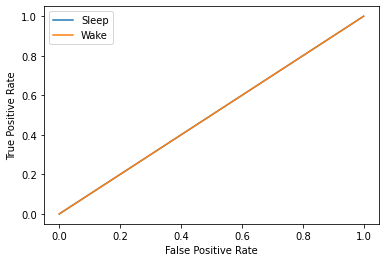

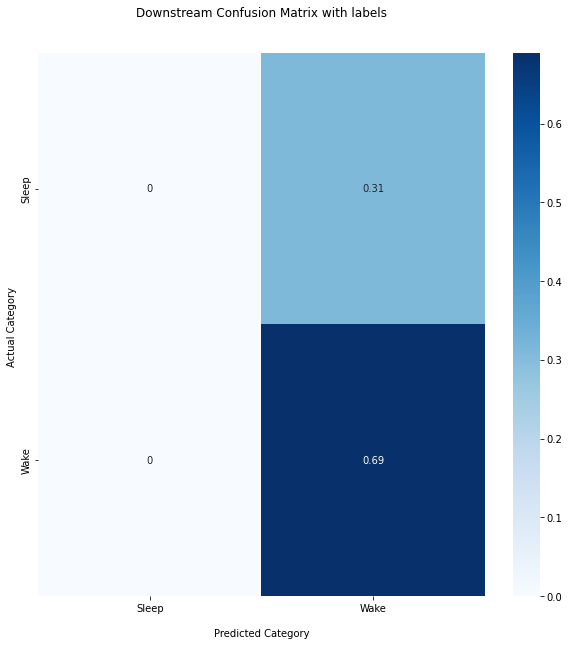

([nan, 0.69], 0.69)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(49, kernel_size=(5,1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(7, activation='relu'))
model.add(Dense(2, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_wake, validation_data=(x_test, y_test_wake), batch_size=16, epochs=15)

test_labels = np.argmax(y_test_wake_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep pos

Epoch 1/15
17564/17564 [==============================] - 23s 1ms/step - loss: 1.2945 - accuracy: 0.5312 - val_loss: 1.8150 - val_accuracy: 0.4400
Epoch 2/15
17564/17564 [==============================] - 23s 1ms/step - loss: 1.2931 - accuracy: 0.5313 - val_loss: 1.9172 - val_accuracy: 0.4400
Epoch 3/15
17564/17564 [==============================] - 22s 1ms/step - loss: 1.3020 - accuracy: 0.5313 - val_loss: 1.9419 - val_accuracy: 0.4400
Epoch 4/15
17564/17564 [==============================] - 21s 1ms/step - loss: 1.3094 - accuracy: 0.5313 - val_loss: 1.9090 - val_accuracy: 0.4400
Epoch 5/15
17564/17564 [==============================] - 22s 1ms/step - loss: 1.3057 - accuracy: 0.5313 - val_loss: 1.9630 - val_accuracy: 0.4400
Epoch 6/15
17564/17564 [==============================] - 22s 1ms/step - loss: 1.3068 - accuracy: 0.5313 - val_loss: 1.9396 - val_accuracy: 0.4400
Epoch 7/15
17564/17564 [==============================] - 22s 1ms/step - loss: 1.3029 - accuracy: 0.5313 - val_loss: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


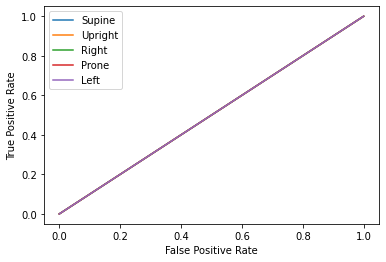

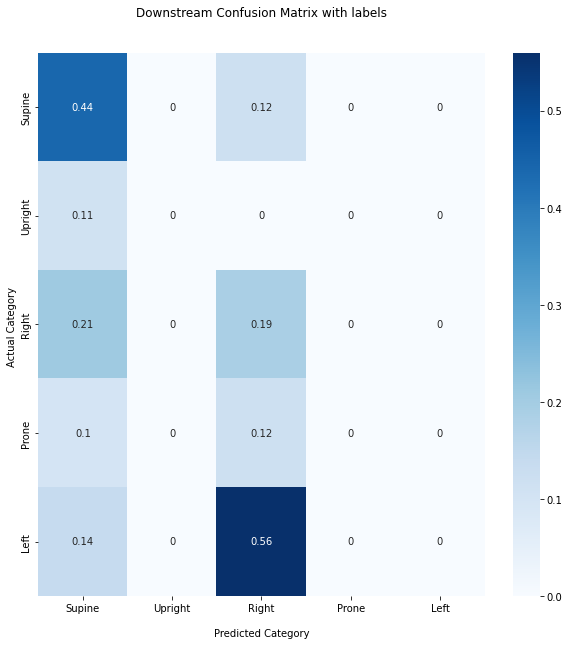

([0.44, nan, 0.19, nan, nan], 0.44)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(70, kernel_size=(7,1), strides=(1,1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_pos, validation_data=(x_test, y_test_pos), batch_size=1, epochs=15)

test_labels = np.argmax(y_test_pos_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep hr

Epoch 1/15
372128/372128 [==============================] - 878s 2ms/step - loss: 2.4159 - accuracy: 0.8574 - val_loss: 36.0420 - val_accuracy: 0.8259
Epoch 2/15
372128/372128 [==============================] - 836s 2ms/step - loss: 1.8240 - accuracy: 0.8632 - val_loss: 2.5456 - val_accuracy: 0.8259
Epoch 3/15
372128/372128 [==============================] - 879s 2ms/step - loss: 2.0722 - accuracy: 0.8639 - val_loss: 6.7054 - val_accuracy: 0.8259
Epoch 4/15
372128/372128 [==============================] - 818s 2ms/step - loss: 2.9477 - accuracy: 0.8641 - val_loss: 2.0347 - val_accuracy: 0.8259
Epoch 5/15
372128/372128 [==============================] - 817s 2ms/step - loss: 4.8341 - accuracy: 0.8651 - val_loss: 1.7511 - val_accuracy: 0.8259
Epoch 6/15
372128/372128 [==============================] - 1454s 4ms/step - loss: 4.3934 - accuracy: 0.8650 - val_loss: 2.7925 - val_accuracy: 0.8259
Epoch 7/15
372128/372128 [==============================] - 959s 3ms/step - loss: 3.9770 - accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


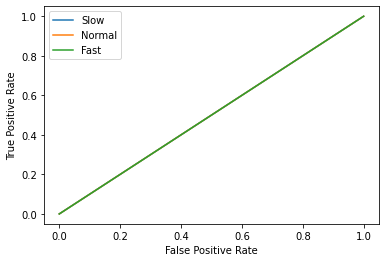

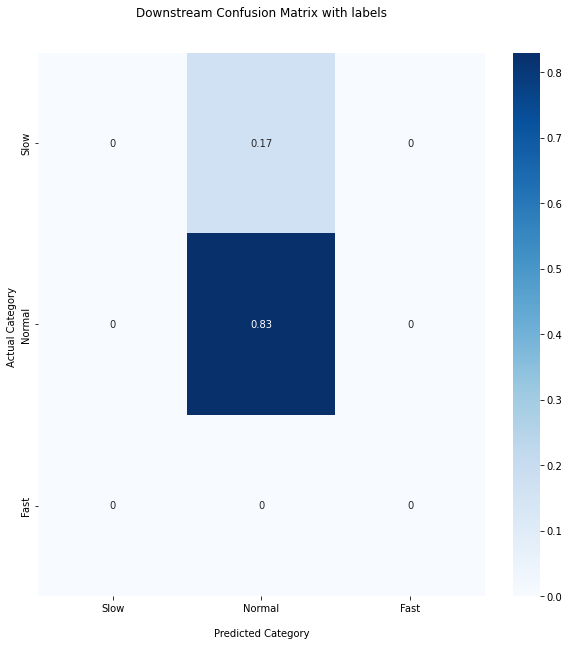

([nan, 0.83, nan], 0.83)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(49, kernel_size=(7,1), strides=(7, 1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(7, activation='relu'))
model.add(Dense(3, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_hr, validation_data=(x_test, y_test_hr), batch_size=1, epochs=15)

test_labels = np.argmax(y_test_hr_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Confusion

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

#printConfusionMatrix(y_test, y_pred, Labels, show=True)

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)
    
    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      if (cf_matrix[i][j] == 0):
        cf_mat[i][j] = 0
      else:
        cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Downstream Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)